# Celebrity Facial Recognition

This project focuses on the use of higher-order discriminant analysis (HODA) for classifying celebrity photos. HODA is an supervised feature extraction algorithm, and this notebook implements an algorithm as outlined in "Tensor decompositions for feature extraction and classification of high dimensional datasets" by Anh Huy Phan and Andrzej Cichocki [1].

### Importing Libraries and Data

The dataset is from Kaggle and can be found here:
https://www.kaggle.com/datasets/bhaveshmittal/celebrity-face-recognition-dataset

In [1]:
import numpy as np
import pandas as pd
import zipfile
import io
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import seaborn as sns
%matplotlib inline
import tensorly as tl
from tensorly.tenalg import multi_mode_dot
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from collections import defaultdict
from tqdm.notebook import tqdm

In [3]:
target_shape = (240, 240)

X = []
y = []

zip_path = 'archive.zip'
i = 0
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    try:
        for file in zip_ref.infolist():
            folder_name = file.filename.split('/')[0]
            y.append(folder_name)
            with zip_ref.open(file.filename) as image_file:
                img = plt.imread(io.BytesIO(image_file.read()), format='jpeg')
                
                if img.shape[:2] != target_shape:
                    factors = (target_shape[0] / img.shape[0], target_shape[1] / img.shape[1], 1)
                    img = zoom(img, factors, order=3)
                    
                gray_img = (img@np.array([0.2989, 0.5870, 0.1140])).astype(np.float32)
                X.append(gray_img)
    
            i += 1
    except Exception as e:
        print(f'Error on iteration {i}')

X = np.array(X).transpose(1, 2, 0)
y = np.array(y)

print(X.shape, y.shape)

(240, 240, 1800) (1800,)


In [4]:
label_indices = defaultdict(list)
for index, label in enumerate(y):
    label_indices[label].append(index)

train_indices = []
test_indices = []

for label, indices in label_indices.items():
    np.random.shuffle(indices)
    train_indices.extend(indices[:97])
    test_indices.extend(indices[97:100])

X_train, X_test = X[..., train_indices], X[..., test_indices]
y_train, y_test = y[train_indices], y[test_indices]

print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (240, 240, 1649) (1649,)
Testing data shape: (240, 240, 51) (51,)


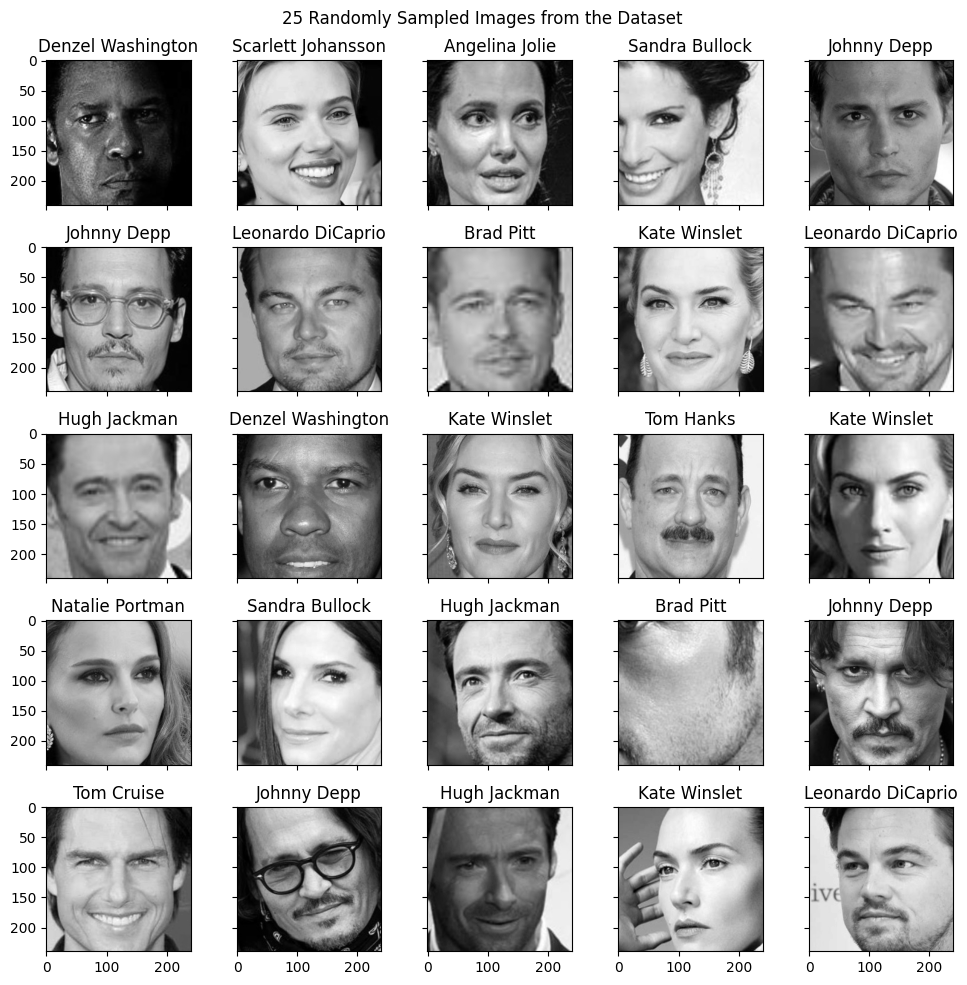

In [5]:
indices = np.random.choice(X_train.shape[2], 25, replace=False)

fig, axes = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[..., indices[i]], cmap='gray')
    ax.set_title(y_train[indices[i]])

fig.suptitle('25 Randomly Sampled Images from the Dataset')
plt.tight_layout()
plt.show()

### Feature Extraction using HODA Algorithm

The HODA algorithm is formulated as such:

**input** : $\underline{\mathbf{X}}$: Concatenated tensor of $K$ training samples $I_1 \times I_2 \times \cdots \times I_N \times K$  
**output** : $\mathbf{U}^{(n)}$: $N$ orthogonal basis factors $I_n \times J_n \ (n = 1, 2, \ldots, N)$  
**output** : $\mathbf{G}$: Training feature tensors $J_1 \times J_2 \times \cdots \times J_N \times K$  

**begin**

- Initialize $\mathbf{U}^{(n)}$
    
- Calculate $\underline{\tilde{\mathbf{X}}}$ and $\underline{\tilde{\mathbf{X}}}^{(c)}$ according to (60) and (63)

    **repeat**
        **for** $n = 1$ to $N$ **do**
$$ \tilde{\mathbf{Z}}_n = \underline{\tilde{\mathbf{X}}} \times_{\{(n,N+1)\}} \{ \mathbf{U}^{(T)} \}$$
$$\mathbf{S}_w^n = \tilde{\mathbf{Z}}_n \tilde{\mathbf{Z}}_n^{(T)}$$
$$\tilde{\mathbf{Z}}_n^b = \underline{\tilde{\mathbf{X}}}^{(c)} \times_{\{(n,N+1)\}} \{ \mathbf{U}^{(T)} \}$$
$$\mathbf{S}_b^n = \tilde{\mathbf{Z}}_n^b \tilde{\mathbf{Z}}_n^{b(T)}$$
$$
\varphi = \frac{\text{trace}(\mathbf{U}^{(n)T} \mathbf{S}_b^n \mathbf{U}^{(n)})}{\text{trace}(\mathbf{U}^{(n)T} \mathbf{S}_w^n \mathbf{U}^{(n)})}
$$
$$
\left[ \mathbf{U}^{(n)}, \Lambda \right] = \text{eigs}(\mathbf{S}_b^n - \varphi \mathbf{S}_w^n, J_n, 'LM')
$$
$$
or /> [\mathbf{U}^{(n)}, \Lambda] = \text{eigs}(\mathbf{S}_b^n, \mathbf{S}_w^n, J_n, 'LM')
$$
$$
\left[ \mathbf{U}^{(n)}, \Lambda \right] = \text{eigs}(\mathbf{U}^{(n)} \mathbf{U}^{(n)T} \mathbf{X}_{\underline{-n}} \mathbf{X}_{\underline{-n}}^T \mathbf{U}^{(n)} \mathbf{U}^{(n)T}, J_n, 'LM')
$$

- **until** a criterion is met

- $\mathbf{G} = \mathbf{X}_{\underline{-}(N+1)} \left[ \mathbf{U} \right]^T$

**end**

---
(60)
$$
\underline{\tilde{\mathbf{X}}}^{(k)} = \underline{\mathbf{X}}^{(k)} - \underline{\tilde{\mathbf{X}}}^{(c_k)}
$$

---
(63)
$$
\underline{\tilde{\mathbf{X}}}^{(c)} = \sqrt{K_c} \left( \underline{\tilde{\mathbf{X}}}^{(c)} - \underline{\tilde{\mathbf{X}}} \right)
$$


In [6]:
def HODA(X_train, y_train, new_dims, alpha=1.0):
    I, K = X_train.shape[:-1], X_train.shape[-1]
    training_samples = K // len(np.unique(y_train))

    X_c = np.zeros_like(X_train).astype(np.float32)
    for lab in np.unique(y_train)[1:]:
        X_c[..., y_train == lab] = np.mean(X_train[..., y_train == lab].astype(np.float32), axis=-1, keepdims=True)

    X_mean = np.mean(X_train.astype(np.float32), axis=-1, keepdims=True)

    U_n = [np.random.rand(I[i], new_dims[i]).astype(np.complex64) for i in range(len(new_dims))]

    X_v = np.sqrt(training_samples).astype(np.float32) * (X_c - X_mean)

    X_tilde = X_train.astype(np.float32) - X_c

    for _ in tqdm(range(10), desc='Total Iterations'):
        for n in range(len(new_dims)):
            Z_tilde = tl.unfold(multi_mode_dot(X_tilde.astype(np.complex64), [U_n[i].T for i in range(len(U_n)) if i != n], modes=[i for i in range(len(U_n)) if i != n]), mode=n)

            S_w = (Z_tilde @ Z_tilde.T).astype(np.complex64)

            Z_v = tl.unfold(multi_mode_dot(X_v.astype(np.complex64), [U_n[i].T for i in range(len(U_n)) if i != n], modes=[i for i in range(len(U_n)) if i != n]), mode=n)

            S_b = (Z_v @ Z_v.T).astype(np.complex64)

            phi = np.trace(U_n[n].T @ S_b @ U_n[n]) / np.trace(alpha * (U_n[n].T @ S_w @ U_n[n]) + (1-alpha) * np.eye(new_dims[n]).astype(np.complex64))
            print(phi)

            U_n[n] = np.linalg.eig(S_b - phi * S_w)[1][:, :new_dims[n]]
            
            X_train_unfolded = tl.unfold(X_train.astype(np.complex64), mode=n)

            U_n[n] = np.linalg.eig(U_n[n] @ U_n[n].T @ X_train_unfolded @ X_train_unfolded.T @ U_n[n] @ U_n[n].T)[1][:, :new_dims[n]]

    return U_n, phi

def visualize_results(X_test, y_test, model):
    y_pred = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Model accuracy: \033[1m{accuracy}\033[0m')

    conf_matrix = confusion_matrix(y_test, y_pred)
    
    clf_report = classification_report(y_test, y_pred, output_dict=True)
    clf_df = pd.DataFrame(clf_report).transpose()
    
    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Spectral', ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    sns.heatmap(clf_df.iloc[:-1, :-1], annot=True, cmap='icefire', fmt='.2f', ax=axes[1])
    axes[1].set_title('Classification Report')

    plt.show()
    
    return clf_df.T

In [7]:
new_dims = (10, 10)
U_n, phi = HODA(X_train, y_train, new_dims, alpha=1e7)
print('Phi at Convergence:', phi)

Total Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

(7.379663e-06+0j)
(6.6974667e-06-5.2979386e-27j)
(4.014042e-06+1.3627785e-26j)
(3.961325e-06+1.8549583e-25j)
(3.961579e-06-3.6423276e-26j)
(3.961747e-06-3.3259983e-25j)
(3.9617353e-06+4.5165063e-25j)
(3.9617426e-06+2.738701e-24j)
(3.9617394e-06-1.0480907e-24j)
(3.961739e-06-6.7864e-24j)
(3.9617426e-06+6.961155e-24j)
(3.961742e-06+4.2536077e-23j)
(3.9617416e-06-1.9882013e-23j)
(3.961741e-06-1.2649783e-22j)
(3.961741e-06+1.1028708e-22j)
(3.9617416e-06+6.7779494e-22j)
(3.9617407e-06-3.5868203e-22j)
(3.961741e-06-2.2625335e-21j)
(3.961741e-06+1.7822131e-21j)
(3.961741e-06+1.1001661e-20j)
Phi at Convergence: (3.961741e-06+1.1001661e-20j)


In [8]:
G_train = multi_mode_dot(X_train, [np.real(U.T) for U in U_n], modes=[0, 1])
G_test = multi_mode_dot(X_test, [np.real(U.T) for U in U_n], modes=[0, 1])
G_train = tl.unfold(G_train, mode=-1)
G_test = tl.unfold(G_test, mode=-1)

print(G_train.shape, G_test.shape)

(10, 10, 1649) (10, 10, 51)


### Fitting the Model

Model accuracy: 0.7058823529411765


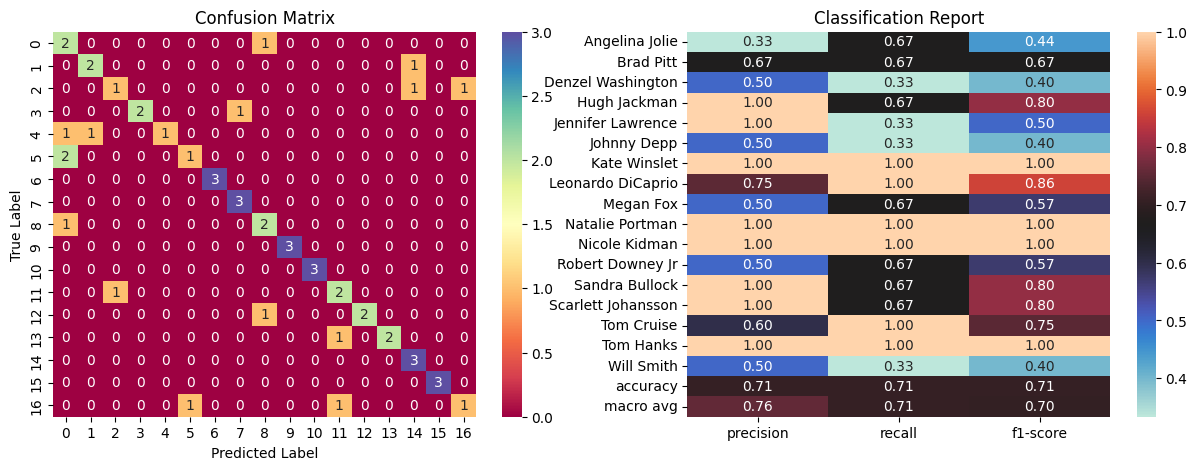

,Angelina Jolie,Brad Pitt,Denzel Washington,Hugh Jackman,Jennifer Lawrence,Johnny Depp,Kate Winslet,Leonardo DiCaprio,Megan Fox,Natalie Portman,Nicole Kidman,Robert Downey Jr,Sandra Bullock,Scarlett Johansson,Tom Cruise,Tom Hanks,Will Smith,accuracy,macro avg,weighted avg
precision,0.333333,0.666667,0.500000,1.000000,1.000000,0.500000,1.0,0.750000,0.500000,1.0,1.0,0.500000,1.000000,1.000000,0.60,1.0,0.500000,0.705882,0.755882,0.755882
recall,0.666667,0.666667,0.333333,0.666667,0.333333,0.333333,1.0,1.000000,0.666667,1.0,1.0,0.666667,0.666667,0.666667,1.00,1.0,0.333333,0.705882,0.705882,0.705882
f1-score,0.444444,0.666667,0.400000,0.800000,0.500000,0.400000,1.0,0.857143,0.571429,1.0,1.0,0.571429,0.800000,0.800000,0.75,1.0,0.400000,0.705882,0.703595,0.703595
support,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0,3.000000,3.000000,3.0,3.0,3.000000,3.000000,3.000000,3.00,3.0,3.000000,0.705882,51.000000,51.000000


In [10]:
svc_model = SVC(probability=True, C=100, kernel='rbf', gamma='scale')
svc_model.fit(G_train, y_train)
visualize_results(G_test, y_test, svc_model)

## References

[1] Anh Huy Phan, Andrzej Cichocki, Tensor decompositions for feature extraction and classification of high dimensional datasets, Nonlinear Theory and Its Applications, IEICE, 2010, Volume 1, Issue 1, Pages 37-68, Released on J-STAGE October 01, 2010, Online ISSN 2185-4106, https://doi.org/10.1587/nolta.1.37, https://www.jstage.jst.go.jp/article/nolta/1/1/1_1_37/_article/-char/en